In [1]:
(ql:quickload "kenzo")
(in-package :cat)

To load "kenzo":
  Load 1 ASDF system:
    kenzo
; Loading "kenzo"



#<PACKAGE "CAT">

# Chain Complexes

## Introduction

In the Kenzo program, a *chain complex* $(C_p, d_p)$ is a collection of free $\mathbb{Z}$-modules $(C_p)$, one for each
$p \in \mathbb{Z}$, together with a homomorphism $d_p : C_p \rightarrow C_{p-1}$, such
that, for all $p$, $d_{p-1} \circ d_p = 0$. (See, for example, __P.J. Giblin__ in *Graph, Surface and Homology*, Chapman and Hall Math. series, 1981.)

In the Kenzo program, a *morphism* $f=(f_p)$, of degree $k$, from a chain complex $(C_p, d_p)$ to another $(C'_p, d'_p)$ is a collection of homomorphisms

$$f_p : C_p \rightarrow C'_{p+k}.$$

This is expressed by the following diagram, generally not assumend commutative .

$$
\begin{aligned}
\cdots & \leftarrow & C_{p-1} & \quad\xleftarrow{d_p} & C_p & \quad\xleftarrow{d_{p+1}} & C_{p+1}  & \quad\leftarrow & \cdots \\
       &    & f_{p-1} \Bigg\downarrow &    & f_p \Bigg\downarrow &    & f_{p+1} \Bigg\downarrow \\
\cdots & \leftarrow & C'_{p+k-1} & \quad\xleftarrow{d'_{p+k}} & C'_{p+k} & \quad\xleftarrow{d'_{p+k+1}} & C'_{p+k+1} & \quad\leftarrow & \cdots \end{aligned}
$$

Three types of   morphisms are most generally considered.

1. $k=0$. If the commutativity relation $d'_p\circ f_p=f_{p-1}\circ d_p$ holds for every $p$, then the morphism $f$ is an ordinary chain complex morphism or *chain map*.
2. $k=-1$. If $(C_p,d_p)=(C'_p,d'_p)$ and $f_p=d_p$, then $f$ is the *differential* of the chain complex $(C_p,d_p)$ and, in fact, this differential is implemented in the ${\tt Kenzo}$ program as a morphism of degree $-1$. Also, if $d_p \neq f_p$ and $(d_{p-1}+f_{p-1})(d_p+f_p) = 0$ for every $p$, then $f_\ast$ is a perturbation of the differential $d_\ast$.
3. $k=+1$. In this case, $f$ is usually a *homotopy operator*, that is, some relation $$d'_{p+1}\circ f_p+f_{p-1}\circ d_p=g_p-g'_p$$ is satisfied for two (ordinary) chain complex morphisms $g_\ast$ and $g'_\ast$, and $f_\ast$ is a homotopy between $g_\ast$ and $g'_\ast$.

For technical reasons, these three types of morphisms have been implemented in the `Kenzo` program
in a unique type.


## Generators, terms, and combinations

To become familiar with the Lisp functions implementing the chain complexes, the best is to begin with an example. *Simplicial complexes* are good candidates for this purpose, and we shall take as a typical example the following simplicial complex.

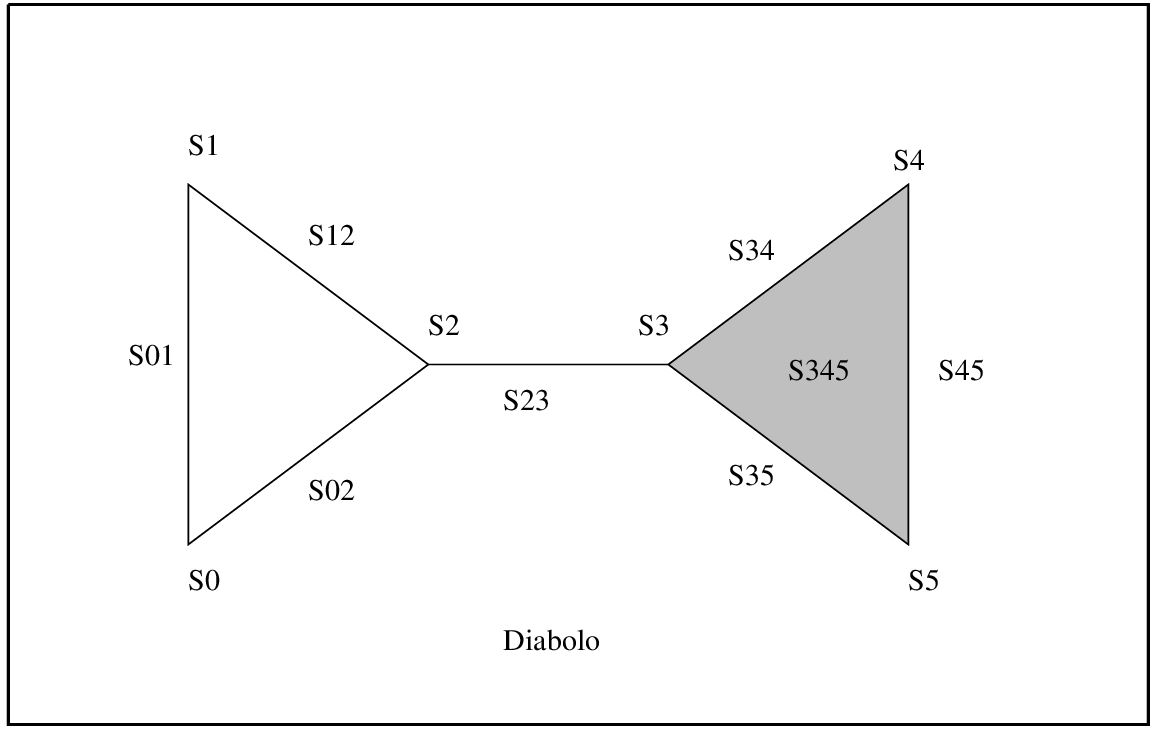

In [2]:
(cl-jupyter-user:png-from-file "diabolo.png")

In this simplicial complex, called here *diabolo*, there are 3 non-null chain groups.

* $C_0$, the free $\mathbb{Z}$-module on the set of vertices $\{s_0,s_1,s_2,s_3,s_4,s_5\}$
* $C_1$, the free $\mathbb{Z}$-module on the set of edges $\{s_{01},s_{02},s_{12},s_{23},s_{34},s_{35}, s_{45}\}$
* $C_2$, the free $\mathbb{Z}$-module on the set of triangles (here a singleton) $\{s_{345}\}$

The elements of either of those groups $C_p$ are linear integer combinations of the corresponding basis $\beta_p$, i.e. elements of the form:
$$
\sum_{b \in \beta_p} \lambda_b b.
$$
For example $2 s_{02} - 3 s_{34} \in C_1$. An element $b$ of the basis $\beta_p$ of $C_p$ is called a *generator* of $C_p$ and in our specific case this generator will be represented by a Lisp symbol. For instance, $s_{45}$ will be translated into `s45`. However, the user should be aware that in more realistic usage of the software, generators may be of any type. A product such as $\lambda_i\sigma_i$ is called a *term* and a sum of terms, a *combination*.

### Representation of a combination

A combination is represented internally in the system by a structure having the following general form:

$$\#\texttt{S(CMBN}\quad\texttt{DEGREE P}\quad\texttt{LIST (}\texttt{(}\lambda_1\cdot\sigma_1\texttt{)}\dots\texttt{(}\lambda_k\cdot\sigma_k\texttt{)))}$$
and containing

1. The degree of the combination corresponding to the index $p\in\mathbb{Z}$ of the group $C_p$ to which this combination belongs.
2. The list of the internal representation of the terms, namely the list of pairs $(\lambda_i\cdot\sigma_i)$.

This choice of representation implies that only homogeneous combinations will be considered. The type `CMBN` and a printing method are provided with this internal representation. The external form of a combination is shown in the examples.

### Ordering the generators

In order to speed up the execution of algorithms involving combinations, the list of pairs $(\lambda_i.\sigma_i)$ is ordered by an adequate ordering function (ex: the lexicographical ordering on the symbols). For programming convenience, an enumerated type `CMPR` has been defined:
``lisp
(deftype cmpr() '(member :less :equal :greater))
``
A number of macros, functions and methods have been defined on usual sets (symbols, numbers, lists, etc.) taking their value in the set `[:less, :equal, :greater]`. Of course, the user may define its own function for a particular case. There exists functions to compare various couples of usual items:

`(f-cmpr`  *n1 n2*`)` *[Function]* 
> Return `:less`, `:equal`, `:greater`, according to the result of the canonical comparison of both integers *n1* and *n2*.

`(s-cmpr` *symbol1 symbol2*`)` *[Function]* 
> Return  `:less`, `:equal`, `:greater`, according to the result of the lisp comparison functions on the strings `(symbol-name` *symbol1*`)` and `(symbol-name` *symbol2*`)`

`(l-cmpr ` *list1 list2*`)` *[Function]* 
> Return `:less`, `:equal`, `:greater`, according to the lexicographical ordering of the two lists *list1*
and *list2*, making sense only if *list1* and *list2* are lists made of integers, symbols and/or lists; in the last case, the qualifier *list* is to be understood recursively.

#### Examples

In [3]:
(f-cmpr 123 789)

:LESS

In [4]:
(s-cmpr 'circulation 'circular)

:GREATER

In [5]:
(s-cmpr 'qwerty 'qwerty)

:EQUAL

In [6]:
(l-cmpr '(1 a b) '(1 a))

:GREATER

1.2.3 Functions handling combinations

The software provides a set of functions, methods, and macros to create or modify combinations.

`(term-cmbn` *dgr cf gnr*`)` *[Macro]* 
> Construct the combination of degree `dgr` with unique term `cf * gnr`.

`(cmbn` *dgr cf1 gnr1 cf2 gnr2 ... cfn gnrn*`)` *[Function]* 
> Construct a combination of degree `dgr`, sum of the terms $cf_i *  gnr_i$. The sequence of pairs $\lbrace cf_i\ gnr_i\rbrace$ has an undefinite length and may be void. In this case, the combination is a null combination of degree `dgr`. It is the responsability of the user to properly order the terms of the combination, otherwise later calculations with this combination could work erroneously. This point can be checked by the `do-control` function. **[I suggest to insert here two appropriate examples.]**

`(cmbn-p` *object*`)` *[Function]* 
> Test is `object` is a legal combination.

`(cmbn-degr` *cmbn*`)` *[Macro]* 
> Get the degree (an integer) of the combination `cmbn`.

`(cmbn-list` *cmbn*`)` *[Macro]* 
> Get the list of the terms  of the combination `cmbn`. Beware: a term is not a structure object, it is a simple `cons` `(cffc . gnrt)`, a pair coefficient - generator. Given a term, one may select the coefficient (an integer) or the generator - a `Kenzo` object - respectively by the macros `cffc` and `gnrt`.

`(zero-cmbn` *dgr*`)` *[Function]* 
> Create an instance of a null combination in the degree `dgr`.

`(cmbn-zero-p` *cmbn*`)` *[Macro]* 
> Test if `cmbn` is a null combination in any degree.

`(cmbn-non-zero-p` *cmbn*`)` *[Macro]* 
> Test if `cmbn` is a non-null combination in any degree.

`(cmbn-opps` *cmbn*`)` *[Function]*
> Create a combination opposite to `cmbn`.

`(n-cmbn` *n cmbn*`)` *[Function]* 
> Create a  combination multiple of `cmbn` by the factor `n`.

`(2cmbn-add cmpr` *cmbn1 cmbn2*`)` *[Function]*
> Create a combination, sum of both combinations `cmbn1` and `cmbn2`. The first argument, `cmpr`, must be the comparison function available in the slot `cmpr` of the underlying chain complex, required to properly merge the terms of both combinations.

`(ncmbn-add` *cmpr cmbn1 cmbn2 ... cmbnk*`)` *[Function]* 
> Create a combination, sum of the indefinite number of combinations $cmbn_i$. As to the first argument, `cmpr`, see the function `2cmbn-add`.

`(2n-2cmbn` *cmpr n1 cmbn1 n2 cmbn2*`)` *[Function]* 
> Build the combination `n1 * cmbn1 + n2 * cmbn2`. Both integers `n1` and `n2` must be
non null. As to the first argument, `cmpr`, see the function `2cmbn-add`.

`(2cmbn-sbtr` *cmpr cmbn1 cmbn2*`)` *[Function]* 
> Create a combination, difference of `cmbn1` and `cmbn2`. As to the first argument, `cmpr`, see the function `2cmbn-add`.

#### Examples

In [7]:
(def comb1 (cmbn 1 1 'u 2 'v 3 'w 4 'z))


----------------------------------------------------------------------{CMBN 1}
<1 * U>
<2 * V>
<3 * W>
<4 * Z>
------------------------------------------------------------------------------


In [8]:
(cmbn-non-zero-p comb1)

T

In [9]:
(cmbn-list comb1)

((1 . U) (2 . V) (3 . W) (4 . Z))

In [10]:
(def term3 (third *))  ;; a simple cons!

(3 . W)

In [11]:
(cffc term3)

3

In [12]:
(gnrt term3)

W

In [13]:
(def mcomb1 (cmbn-opps comb1))


----------------------------------------------------------------------{CMBN 1}
<-1 * U>
<-2 * V>
<-3 * W>
<-4 * Z>
------------------------------------------------------------------------------


In [14]:
(def comb2 (n-cmbn 10 comb1))


----------------------------------------------------------------------{CMBN 1}
<10 * U>
<20 * V>
<30 * W>
<40 * Z>
------------------------------------------------------------------------------


In [15]:
(def cmb12 (2cmbn-add #'s-cmpr comb1 comb2))


----------------------------------------------------------------------{CMBN 1}
<11 * U>
<22 * V>
<33 * W>
<44 * Z>
------------------------------------------------------------------------------


In [16]:
(2cmbn-sbtr #'s-cmpr comb1 cmb12)


----------------------------------------------------------------------{CMBN 1}
<-10 * U>
<-20 * V>
<-30 * W>
<-40 * Z>
------------------------------------------------------------------------------


In [17]:
(ncmbn-add #'s-cmpr
           comb1 comb2 comb1 comb2 comb1 comb2 comb1 comb2 comb1 comb2)


----------------------------------------------------------------------{CMBN 1}
<55 * U>
<110 * V>
<165 * W>
<220 * Z>
------------------------------------------------------------------------------


## Representation of a chain complex

A chain complex is implemented as an instance of a `CLOS` class, 
the class `CHAIN-COMPLEX`, whose definition is

```commonlisp
(DEFCLASS CHAIN-COMPLEX ()
    ((cmpr  :type cmprf :initarg :cmpr  :reader cmpr1)
     (basis :type basis :initarg :basis :reader basis1)
     ;; BaSe GeNerator
     (bsgn :type gnrt :initarg :bsgn :reader bsgn)
     ;; DiFFeRential
     (dffr :type morphism :initarg :dffr :reader dffr1)
     ;; GRound MoDule
     (grmd :type chain-complex :initarg :grmd :reader grmd)
     ;; EFfective HoMology
     (efhm :type homotopy-equivalence :initarg :efhm :reader efhm)
     ;; IDentification NuMber
     (idnm :type fixnum :initform (incf *idnm-counter*) :reader idnm)
     ;; ORiGiN
     (orgn :type list :initarg :orgn :reader orgn)))
```

This class has 8 slots:

1. `cmpr`, a comparison function or method for  generators with a range in the set `[:less, :equal, :greater]`. It is very important to note that the generators to be compared are assumed to be of the *same degree*, i.e. they must belong to the same group $C_p$. As an exception with the general policy of the program, this degree is not explicitly precised. The implementor has chosen to avoid additional tests because in real problems the program spends a lot of time comparing generators.
2. `basis`, a lisp function giving the distinguished **ordered** basis of the free $\mathbb{Z}$-modules ($C_p$). (Recall that in the program, only free chain complexes are considered.) When some  components of the chain complex are not finitely generated, we say that the chain complex is *locally effective*. In this case the value of this slot must be the keyword `locally-effective`.
3. `bsgn`, a lisp object of any type representing a distinguished generator in dimension 0, the base generator. 
4. `dffr`, the differential morphism, instance of the class `MORPHISM`, defined hereafter. The pure lisp function corresponding to the differential homomorphism for each $p$ ($d_p : C_p \rightarrow C_{p-1}$) is defined in the instance morphism object and not directly in the instance chain complex object.
5. `idnm`, an integer, number plate for this object. This is generated by the system in a sequential way, each time a new `Kenzo` object is created.
6. `orgn`, a list containing a comment to recall to the user the *origin* of the object. This comment must be chosen with care because, when the user creates a new chain complex instance, the  system `Kenzo` uses the comment list information to search in a specific list (here `*chcm-list*`) if the object has not been already built. So, one avoids the  duplication of instances of the same object.

The two slots `grmd` and `efhm` will be explained later. The accessors of the slots are the functions whose name appears after the specifier `:reader` in the class definition. A printing method has been associated to the class `CHAIN-COMPLEX` and the external representation of a chain complex instance is a string like `[Kn Chain-Complex]`, 
where `n` is the number plate of this `Kenzo` object.


### The function `build-chcm`

To facilitate the construction of instances of the class `CHAIN-COMPLEX` and to free the user to call
the standard constructor `make-instance`, the software provides the function

`build-chcm`
> `:cmpr` *cmpr* `:basis` *basis* `:bsgn` *bsgn* `:intr-dffr` *intr-dffr* `:strt` *strt* `:orgn` *orgn*

defined with keyword parameters. The returned value is an instance of the class `CHAIN-COMPLEX`. In particular, this function frees the user to build himself the instance of the class `MORPHISM` corresponding to the differential homomorphism. The keyword arguments of `build-chcm` are:

- `cmpr`, the comparison function for generators.
- `basis`, the function defining the distinguished  basis of the free $\mathbb{Z}$-modules $C_p$ or the keyword `:locally-effective`.
- `bsgn`, a generator, the base point of the underlying set.
- `intr-dffr`, a **lisp function** defining the differential homomorphism for each $p$ ($d_p : C_p \rightarrow C_{p-1}$).
- `strt`, one of the two values: `:gnrt` or `:cmbn`, defining the mapping *strategy* of the differential homomorphism, either by generator or by combination. The default is `:gnrt`. The real connection between the  arguments `intr-dffr` and `strt`will be detailed hereafter through typical examples. The general idea is the following: if the strategy is `:gnrt`, the `:intr-dffr` argument function  uses two arguments, namely a degree and a generator of this degree and computes the boundary combination of this generator. If the strategy is `:cmbn`, the `:intr-dffr` argument function uses a combination as argument and computes the boundary combination of this argument. We recall that a combination contains its own degree.
- `orgn`, a list containing  a relevant and carefully chosen  comment about the `origin` of the chain complex. If, during a Lisp session, the user wishes to  modify any slot of an existing chain complex, by calling again `build-chcm`, he must change also the comment, otherwise the new version of the object will not be created. This remark is valid for any kind of instantiation of `Kenzo` objects. The function `cat-init` reinitializes the environment, that is, the previous relations `orgn` $\rightarrow$ Kenzo objects are deleted.


After creation of an instance of chain complex, the function `build-chcm` pushes this
object in the list of already created chain complexes `*chcm-list*`.

#### A first example of a chain complex

Let us consider our small example *diabolo*. We shall give the same name to the corresponding chain complex  instance. Let us define, one by one, the values of the key parameters, though it is possible to put them directly in the `build-chcm` call. First, the function `s-cmpr`, already seen above, is  the natural choice to compare generators, which are here, lisp symbols:

In [18]:
(def diabolo-cmpr #'s-cmpr)

#<FUNCTION S-CMPR>

The function for the basis consists in enumerating the distinguished basis as lisp lists according to the degree:

In [19]:
(def diabolo-basis #'(lambda (dmn)
                             (case dmn
                                 (0 '(s0 s1 s2 s3 s4 s5))
                                 (1 '(s01 s02 s12 s23 s34 s35 s45))
                                 (2 '(s345))
                                 (otherwise nil))))

#<FUNCTION (LAMBDA (DMN) :IN "/root/cl-jupyter/cl-jupyter.lisp") {1001FA0ADB}>

For the base point, we may choose any vertex:

In [20]:
(def diabolo-bspn 's0)

S0

The lisp function for the differential homomorphism, also called boundary homomorphism, computes the boundary of each generator, in this case, according to the classical (simplicial) rule:

$$ {\bf d}[{s_0s_1\ldots s_n}] = \sum_{i=0}^n{(-1)^is_0s_1\ldots\widehat{s_i}\ldots s_n}.$$

It must be noted that our differential uses a predefined choice for the order of the vertices.

In [21]:
(def diabolo-pure-dffr
         #'(lambda (dmn gnr)
                   (unless (<= 0 dmn 2)
                       (error "Incorrect dimension for diabolo-dp."))
                   (case dmn
                       (0 (cmbn -1))  ; Note the null combination of degree -1
                       (1 (case gnr
                              (s01 (cmbn 0 -1 's0 1 's1))
                              (s02 (cmbn 0 -1 's0 1 's2))
                              (s12 (cmbn 0 -1 's1 1 's2))
                              (s23 (cmbn 0 -1 's2 1 's3))
                              (s34 (cmbn 0 -1 's3 1 's4))
                              (s35 (cmbn 0 -1 's3 1 's5))
                              (s45 (cmbn 0 -1 's4 1 's5))))
                       (2 (case gnr
                              (s345 (cmbn 1 1 's34 -1 's35 1 's45))))
                       (otherwise (error "Bad generator for complex diabolo")))))

#<FUNCTION (LAMBDA (DMN GNR) :IN "/root/cl-jupyter/cl-jupyter.lisp") {10021380BB}>

The  strategy is by generator and the comment recalls the name of the problem:

In [22]:
(def diabolo-strt :GNRT)

:GNRT

In [23]:
(def diabolo-orgn '(diabolo-for-example))

(DIABOLO-FOR-EXAMPLE)

The effective call to `build-chcm` is now reduced to:

In [24]:
(def diabolo (build-chcm :cmpr diabolo-cmpr :basis diabolo-basis
                         :bsgn diabolo-bspn :intr-dffr diabolo-pure-dffr
                         :strt diabolo-strt :orgn diabolo-orgn))

[K1 Chain-Complex]

The value of the symbol `diabolo` is the `CHAIN-COMPLEX` instance which is here the first created `Kenzo` object. The string `[K1 Chain-Complex]` is printed by the printing method associated to the class.

### Simple functions handling chain complexes

`(cat-init)` *[Function]*
> Clear among others, the list `*chcm-list*`, list of user created chain complexes  and reset the global counter to 1. The existing objects and in particular here the chain complexes, are not destroyed but they will not enter any more in account during the search process for duplicated objects. This remark is general for the other types of objects saved in specific lists. 

`(chcm` *n*`)` *[Function]*
> Return from the list `*chcm-list*` the chain complex instance whose the Kenzo identification is `n`; if it does not exist, return `NIL`.

`(cmpr` *object item1 item2*`)` *[Macro]*
> Apply the comparison function associated to the chain complex `object` to the two generators `item1` and `item2`.

`(basis` *object n*`)` *[Macro]*
> With only one argument (`object`), get the  function attached to the slot `basis` of the chain complex object. With two arguments, get the distinguished basis of the group of degree `n` in the chain complex `object`. If the chain complex is locally effective, this function returns an error because, in some degrees, the corresponding set of generators is probably infinite.

`(dffr` *chcm* `&rest)` *[Macro]* 
> Versatile macro to apply the differential morphism of the chain complex `chcm` either to a combination or a generator with a degree, respectively `(dffr chcm cmbn)` or `(dffr chcm degr gnrt)`. The macro `?`, described later, may be used for the same purpose.

`(z-chcm)` *[Function]* 
> Build the unit chain complex (see hereafter).

#### Examples

Let us apply some accessors functions and the simple  functions above to the chain complex `diabolo`. First, we see that the list `*chcm-list*` contains only one element, namely the chain complex just created.

In [25]:
*chcm-list*

([K1 Chain-Complex])

In [26]:
(chcm 1)

[K1 Chain-Complex]

In [27]:
(orgn diabolo)

(DIABOLO-FOR-EXAMPLE)

In [28]:
(idnm diabolo)

1

In [29]:
(basis diabolo 0)

(S0 S1 S2 S3 S4 S5)

In [30]:
(basis diabolo 1)

(S01 S02 S12 S23 S34 S35 S45)

In [31]:
(basis diabolo 2)

(S345)

In [32]:
(basis diabolo 10)

NIL

In [33]:
(dffr diabolo 2 's345)


----------------------------------------------------------------------{CMBN 1}
<1 * S34>
<-1 * S35>
<1 * S45>
------------------------------------------------------------------------------


In [34]:
(dffr diabolo *)


----------------------------------------------------------------------{CMBN 0}
------------------------------------------------------------------------------


#### An important trivial case: the unit chain complex, $\mathbb{Z}$

The unit chain complex, has a unique non null component, namely a $\mathbb{Z}$-module of degree 0 generated by a unique generator, called here `:Z-gnrt`. It is defined by the following call to `build-chcm`:

In [35]:
(def ZCC
    (the chain-complex
         (build-chcm
          :cmpr #'(lambda (gnrt1 gnrt2)
                          (declare (ignore gnrt1 gnrt2))
                          (the cmpr :equal))
          :basis #'(lambda (n)
                           (the list
                                (if (zerop n) '(:Z-gnrt) +empty-list+)))
          :bsgn :Z-gnrt
          :intr-dffr #'(lambda (cmbn)
                               (the cmbn (zero-cmbn (1- (cmbn-degr cmbn)))))
          :strt :cmbn
          :orgn '(zcc-constant))))

[K3 Chain-Complex]

In this definition,

1. The `:cmpr` keyword argument is a function  returning `:equal` on any pair on generators (because there is a unique generator!).
2. The `:basis` keyword argument is a lisp function returning the null basis (the constant `+empty-list+ = ()`) for $p \not= 0$ and the list `(:Z-gnrt)`, for $p=0$.
3. The base generator is of course `Z-gnrt`.
4. The `:intr-dffr` keyword argument is a lisp function defining the differential  which, to any combination of degre $p$ of the chain complex, returns a *null combination* of degree $p-1$. This simple lisp function is also provided in `Kenzo` and is called `#'zero-intr-dffr`.
5. The `:strt` keyword argument is the combination strategy (`:cmbn`).
6. The `:orgn` keyword argument is the comment list `(zcc-constant)`.

In the program `Kenzo`, the chain complex instance `ZCC` may be built, when needed, by the lisp statement: `(z-chcm)`. This statement may be used freely each time one needs this chain complex, since the system  recognizes if it has already been created.

#### The chain complex `circle`

On the model of the previous chain complex, one may define a function `circle` for building the chain complex associated to the standard model of the circle as a simplicial set.

In [36]:
(defun MY-CIRCLE ()
    (the chain-complex
         (build-chcm
          :cmpr #'(lambda (gnrt1 gnrt2)
                          (declare (ignore gnrt1 gnrt2))
                          (the cmpr :equal))
          :basis #'(lambda (dmns)
                           (the list
                                (case dmns (0 '(*)) (1 '(s1))
                                    (otherwise +empty-list+))))
          :bsgn '*
          :intr-dffr #'zero-intr-dffr
          :strt :cmbn
          :orgn '(circle))))

MY-CIRCLE

## Morphisms

Algebraic Topology uses morphisms between chain complexes and the differential homomorphism may be considered as a particular case of  morphism. A morphism is implemented in the system as an instance of the class `MORPHISM`, whose definition is:

```commonlisp
(DEFCLASS MORPHISM ()
     ;; SOuRCe
    ((sorc :type chain-complex :initarg :sorc :reader sorc)
     ;; TaRGeT
     (trgt :type chain-complex :initarg :trgt :reader trgt)
     ;; DEGRee
     (degr :type fixnum :initarg :degr :reader degr)
     ;; INTeRnal
     (intr :type intr-mrph :initarg :intr :reader intr)
     ;; STRaTegy
     (strt :type strt :initarg :strt :reader strt)
     ;; CaLl NuMber
     (???-clnm :type fixnum :initform 0 :accessor ???-clnm)
     (?-clnm :type fixnum :initform 0 :accessor ?-clnm)
     ;; ReSuLTS
     (rslts :type simple-vector  :reader rslts)
     ;; IDentification NuMber
     (idnm :type fixnum :initform (incf *idnm-counter*) :reader idnm)
     ;; ORiGiN
     (orgn :type list :initarg :orgn :reader orgn)))
```

This class has 10 slots:

1. `sorc`, an object of the class `CHAIN-COMPLEX`, namely the *source* chain complex of this morphism.
2. `trgt`, an object of the class `CHAIN-COMPLEX`, namely the *target* chain complex of this morphism.
3. `degr`, an integer, the degree of the morphism. A morphism is supposed to associate to any element of degree $k$ of the source chain complex, an element of degree $k + degr$ of the target chain complex. For instance, a differential homomorphism is of degree -1.
4. `intr`, a **pure lisp function** implementing the mathematical algorithm of the morphism and taking in account the strategy (`strt`).
5. `strt`, one of the two symbols `:gnrt`, `:cmbn`. What has already been said about the strategy of the differential morphism is generalized to any morphism: according  to the value of the argument, `:gnrt` or `:cmbn`, the lisp function attached to the keyword just above, works respectively with 2 arguments (a degree and a generator) or only one (a combination) and must return a combination, image of the generator or the combination argument. 
6. `???-clnm`, an integer updated by the system for statistics (number of times the morphism has been called on combinations - Internal use)
7. `?-clnm`, analogous to the previous field, but for generators.
8. `rslts`, an array of dimension `*maxdim*` reserved by the system to save  computed results in order to avoid  re-computing, for instance, the differential of the same generator. - Internal use.
9. `idnm`, an integer, number plate for this object. This is generated by the system.
10. `orgn`, a relevant comment list.

The accessors of the slots are the functions whose name appears after the specifier `:reader` or after the specifier `:accessor` in the class definition. A printing method has been associated to the class `MORPHISM` and the external representation of an instance is a string like `[Kn Morphism (degree d): Kp -> Kq]` or `[Kn Cohomology-Class (degree d)]` when the chain complex target is the unit $\mathbb{Z}$. In this string, `n` is the number plate of the `Kenzo` object, `d` is the degree of the morphism, `Kp` is the `Kenzo` object source of the morphism and `Kq` the target. In all the  examples of this manual, the last part of the string will not be necessarily printed.

### The function `build-mprh`

To facilitate the construction of instances of the class `MORPHISM` and to free  the user to call the standard constructor `make-instance`, the software provides the function `build-mrph`

`build-mrph`
> `:sorc` *sorc* `:trgt` *trgt* `:degr` *degr* `:intr` *intr* `:strt` *strt* `:orgn` *orgn*


defined with keyword parameters. The returned value is an instance of the class `MORPHISM`. The keyword arguments of `build-mrph` are:

- *sorc*, the source object, a `CHAIN-COMPLEX` type object.
- *trgt*, the target object, a `CHAIN-COMPLEX` type object.
- *degr*, the degree of the morphism, an integer.
- *intr*, the pure lisp function defining the effective mapping.
- *strt*, the strategy, i.e. `:gnrt` or `:cmbn`.
- *orgn*, a relevant comment list.

After a call to `build-mrph`, the morphism instance is added to a list of previously constructed  ones (`*mrph-list*`).

#### The differential homomorphism in a chain complex instance

In a  chain complex instance, the differential homomorphism is defined as a morphism with identical source and target, and degree -1. The user must know that the function `build-chcm` calls internally the function `build-mrph` and passes it the keyword argument `intr-dffr`. The function `build-mrph` builds the  morphism instance which will be then inserted into the slot `:dffr` of the chain complex instance to be constructed.

##### Example

Let us define respectively a *zero--morphism* of degree -1 and an *identity-morphism* (degree 0)  between  the *unit chain complex* `ZCC` and itself.

In [37]:
(cat-init)


---done---

NIL

In [38]:
(def ZCC (z-chcm))

[K1 Chain-Complex]

In [39]:
(def zero-morphism (build-mrph :sorc ZCC
                               :trgt ZCC
                               :degr -1
                               :intr #'(lambda (comb)
                                               (cmbn (1- (degr comb))))
                               :strt :cmbn
                               :orgn '(zero morphism on ZCC)))

[K3 Cohomology-Class on K1 of degree 1]

In [40]:
(def id-morphism (build-mrph :sorc ZCC
                             :trgt ZCC
                             :degr 0
                             :intr #'identity
                             :strt :cmbn
                             :orgn '(identity morphism on ZCC)))

[K4 Cohomology-Class on K1 of degree 0]

On the first morphism, we see that the  `:intr` keyword argument is a lisp function taking any combination of degree `p` of the  unit chain complex and generating a null combination of degree `p-1` of the same chain complex. The second morphism uses the lisp function `identity`.

### Applying morphisms

To apply an already constructed morphism on a generator, one uses the function `gnrt-?`, the usage of which is described hereafter. On a similar way, to apply a morphism on a combination, one uses the function `cmbn-?`. It is very important to note that these functions can be used with the underlying morphism, **whatever strategy had been decided
at creation time by the user for the morphism mapping**. In other words, a morphism defined with the strategy `:gnrt` (resp. `:cmbn`) may be applied to a combination (resp. generator). These functions are mainly used inside the software. For a practical usage, one may use the versatile macro `?`.

`(gnrt-? mrph degr gnrt)` *[Function]*
> Apply the morphism `mrph` on the generator `gnrt` of degree `degr`.

`(cmbn-? mrph cmbn)` *[Function]*
> Apply the morphism `mrph` on the combination `cmbn`.

`(? &rest args)` *[Macro]*
> Versatile macro for applying a morphism  in both cases above, i.e. indifferently as `(? mrph degr gnrt)` or  `(? mrph cmbn)`. If the first argument is a chain complex object, as in `(? chcm degr gnrt)` or in  `(? chcm cmbn)`, then the differential morphism of the chain complex `chcm` is applied to the arguments.

### Functions defining morphisms

The following functions are useful to work on morphisms, particularly to define new morphisms from already defined ones.

`(cat-init)` *[Function]*
> Clear in particular `*mrph-list*`, the list of user created morphisms and reset the global counter to 1.

`(mrph` *n*`)` *[Function]*
> Retrieve in the list `*mrph-list*` the morphism instance whose identification is `n`. If it does not exist, return `NIL`. 

`(zero-mrph` *chcm1* `&optional (`*chcm2 chcm1*`) (`*degr* `0))` *[Function]*
> Construct the null morphism between the chain complexes `chcm1` and `chcm2` of degree `degr`. The parameters `chcm2` and `degr` are optional and if omitted the default values (respectively `chcm1` and 0) are taken.

`(idnt-mrph` *chcm*`)` *[Function]*
> Construct the identity morphism (degree 0) between the chain complex `chcm` and itself.

`(opps` *mrph*`)` *[Function]*
> Construct the opposite morphism of `mrph`, i.e. $-1 \times mrph$; such a function, as well as the following ones, installs the right source and target.

`(cmps` *mrph1 mrph2* `&optional` *strt*`)` *[Method]*
> Construct the  composite of the morphisms, i.e. $mrph_1 \circ\, mrph_2$. Of course, the target of $mrph_2$ must be the same as the source of $mrph_1$, otherwise the system signals an error. The new instance inherits its source slot from $mrph_2$ and its target slot from $mrph_1$. This function optimizes the compositions in which appear zero morphisms or identity morphisms. Unless the user gives explicitly the  strategy (`strt`), the resulting strategy is determined by the respective strategy of the two morphisms.

`(cmps` *chcm1 chcm2* `&optional` *strt*`)` *[Method]*
Construct the composite of the differential of the chain complexes `chcm1` and `chcm2`, i.e. $d_1 \circ d_2$.

`(cmps` *chcm1 mrph2* `&optional` *strt*`)` *[Method]*
> Construct the composite of the differential of the chain complex `chcm1` and the morphism  `mrph2`, i.e. $d_1 \circ mrph_2$.

`(cmps` *mrph1 chcm2* `&optional` *strt*`)` *[Method]*
> Construct the composite of the morphism `mrph1` and the differential of the chain complex `chcm2`, i.e. $mrph_1 \circ d_2$.

`(i-cmps` *mrph1 mrph2 ... mrphk*`)` *[Macro]*
> Construct the  composite of the morphisms, i.e. $mrph_1 \circ\, mrph2 \circ\, \cdots\, \circ\, mrph_k$. Of course, the target of $mrph_i$ must be the same as the source of $mrph_{i-1}$, otherwise the system signals an error. The new instance inherits its source slot from $mrph_k$ and its target slot from $mrph_1$. This function optimizes the compositions in which appear zero morphisms or identity morphisms.

`(add` *mrph1 mrph2* `&optional` *strt*`)` *[Method]*
> Construct a morphism, sum  of the  morphisms $mrph_1$ and  $mrph_2$.  The result of the mapping of the morphism sum is the sum of the results of the mappings of the morphisms. The respective definitions of the morphisms $mrph_1$ and  $mrph_2$  must be coherent, in particular they must have the same  source, target and degree. The user may impose its strategy, otherwise it is defined in the program according to the respective strategy of the arguments.

`(i-add` *mrph1 mrph2 ... mrphk*`)` *[Macro]*
> Construct a morphism, sum  of the  morphism $mrph_1$,  $mrph_2$, $\ldots$, $mrph_k$. The result of the mapping of the morphism sum is the sum of the results of the mappings of the $mrph_i$. The respective definitions of $mrph_i$ must be coherent, in particular they must have the same source, target and degree. The macro `i-add` has an undefinite number of arguments. With one argument, the macro returns that argument.

`(sbtr` *mrph1 mrph2* `&optional` *strt*`)` *[Method]*
> Construct a morphism, difference  of the  morphisms $mrph_1$ and  $mrph_2$. The conditions of validity are similar to those of the method `add`.

`(i-sbtr` *mrph1 mrph2 ... mrphk*`)` *[Macro]*
> Construct a morphism, difference  of the  morphisms $mrph_1$,  $mrph_2$, $\ldots$, $mrph_k$, in the sense $mrph_1 -  mrph_2 - \cdots - mrph_k$. The conditions of validity are similar to those of the method `add` for the morphisms. The macro `i-sbtr` must have at least 2 arguments.

`(change-sorc-trgt` *mrph* `&key` *sorc trgt*`)` *[Function]*
> Build from the morphism `mrph` a new morphism inheriting from `mrph` the slots `:degr` (degree), `:intr` (mapping) and `:strt` (strategy). The source  and target slots of this new morphism are given by the key parameters `sorc` and `trgt`. If any key parameter is omitted, the corresponding slot is inherited from `mrph` (default value). This function is most often used when the old and new sources and/or targets are chain complexes with the same underlying graded modules, but with different differentials. Important to have this tool when handling perturbations of differentials.

`(dstr-change-sorc-trgt` *mrph* `&key` *sorc trgt*`)` *[Function]*
> Modify **destructively** the morphism `mrph`. The source  and target slots of the first argument are replaced respectively by the key parameters `sorc` and `trgt`.

`(add` *chcm perturbation* `&optional` *strt*`)` *[Method]*
> Create from the chain complex `chcm` a new chain complex inheriting from `chcm` the slots `cmpr` and `basis`. The boundary morphism attached to this new chain complex  is the sum of the boundary morphism $d$ of `chcm` (slot `dffr`) and a perturbation morphism $\delta$ represented by the `MORPHISM` instance `perturbation`. Of course, the new boundary operator must satisfy $(d+\delta)\circ (d+\delta)=0$.

#### Examples

In the following examples, we first construct a chain complex instance `ccn` where the groups $C_p$ are freely generated by numerical basis taken formally. These basis are sets of 10 numbers or *decades* produced by the fonction `<a-b<`. For instance, in dimension 0, the basis is $\lbrace 0,1,2,3,4,5,6,7,8,9 \rbrace$, in dimension 1, $\lbrace 10,11,\ldots,19 \rbrace$ and so on.
The differential is defined as follows: for an even dimension $p$ of the group, a generator $k$ is sent to the combination $cmbn (p-1, 1, k-10)$ if $k$ is even and to the null combination of degree $p-1$ if $k$ is odd. The reverse action is taken if $p$ is odd. So, from the programming point of view, it is sufficient to test the parity of $p+k$.

Then, we construct two simple morphisms `upper-shift` and `lower-shift` which respectively apply bijectively a decade on the following one and on the previous one. The generators being integers, the comparative function is of course `f-cmpr`.

In [41]:
(def ccn-boundary #'(lambda (dgr gnr)
                            (if (evenp (+ dgr gnr))
                                (cmbn (1- dgr) 1 (- gnr 10))
                                (cmbn (1- dgr)))))

#<FUNCTION (LAMBDA (DGR GNR) :IN "/root/cl-jupyter/cl-jupyter.lisp") {1002BB447B}>

In [42]:
(def ccn (build-chcm :cmpr #'f-cmpr
                     :basis #'(lambda (n) (<a-b< (* 10 n) (* 10 (1+ n))))
                     :bsgn 0
                     :intr-dffr ccn-boundary
                     :strt :gnrt
                     :orgn '(ccn)))

[K5 Chain-Complex]

In [43]:
(def upper-shift (build-mrph
                  :sorc ccn :trgt ccn :strt :gnrt :degr +1
                  :intr #'(lambda (d gn) (cmbn (1+ d) 1 (+ gn 10)))
                  :orgn '(ccn shift +10)))

[K7 Morphism (degree 1): K5 -> K5]

In [44]:
(def lower-shift (build-mrph
                  :sorc ccn :trgt ccn :strt :gnrt :degr -1
                  :intr #'(lambda (d gn) (cmbn (1- d) 1 (- gn 10)))
                  :orgn '(ccn shift -10)))

[K8 Morphism (degree -1): K5 -> K5]

In [45]:
(? ccn 2 22)


----------------------------------------------------------------------{CMBN 1}
<1 * 12>
------------------------------------------------------------------------------


In [46]:
(? ccn *)  ;(* means the result of the previous command)


----------------------------------------------------------------------{CMBN 0}
------------------------------------------------------------------------------


In [47]:
(def combn (cmbn 5 1 50 5 55 9 59))


----------------------------------------------------------------------{CMBN 5}
<1 * 50>
<5 * 55>
<9 * 59>
------------------------------------------------------------------------------


In [48]:
(? ccn combn)


----------------------------------------------------------------------{CMBN 4}
<5 * 45>
<9 * 49>
------------------------------------------------------------------------------


In [49]:
(? ccn *)


----------------------------------------------------------------------{CMBN 3}
------------------------------------------------------------------------------


Then, let us test the morphisms on generators and combinations.

In [50]:
(? upper-shift 0 6)


----------------------------------------------------------------------{CMBN 1}
<1 * 16>
------------------------------------------------------------------------------


In [51]:
(? lower-shift 5 51)


----------------------------------------------------------------------{CMBN 4}
<1 * 41>
------------------------------------------------------------------------------


We may iterate the mapping  upon the previous result (symbol \*). Note that now, though `lower-shift` has been constructed with 
the strategy `:gnrt`, its works also on a combination.

In [52]:
(? lower-shift *)


----------------------------------------------------------------------{CMBN 3}
<1 * 31>
------------------------------------------------------------------------------


Let us construct new morphisms from `upper-shift` and `lower-shift`. The tests are made upon the degree 1 combination $1*10 + 2*11 + 3*12 +4*13$.

In [53]:
(def comb1 (cmbn 1 1 10 2 11 3 12 4 13))


----------------------------------------------------------------------{CMBN 1}
<1 * 10>
<2 * 11>
<3 * 12>
<4 * 13>
------------------------------------------------------------------------------


The composition of the two morphisms  must be an identity operation. The degree of `identity?` is in the `degr` slot of the morphism object instance and may be read by the function `degr`:

In [54]:
(def identity? (cmps upper-shift lower-shift))

[K9 Morphism (degree 0): K5 -> K5]

In [55]:
(degr identity?)

0

We see now that `identity?` applied on `comb1` returns a combination mathematically equal to `comb1`. No simple lisp comparison can prove this, nevertheless, their mathematical difference is the null combination, as shown by a call to the function `2cmbn-sbtr` applied to two combinations. Note that the function `2cmbn-sbtr` needs the comparison function of the chain complex `ccn`.

In [56]:
(? identity? comb1)


----------------------------------------------------------------------{CMBN 1}
<1 * 10>
<2 * 11>
<3 * 12>
<4 * 13>
------------------------------------------------------------------------------


In [57]:
(2cmbn-sbtr (cmpr ccn) comb1 *)


----------------------------------------------------------------------{CMBN 1}
------------------------------------------------------------------------------


We may compose `upper-shift` with itself:

In [58]:
(def upper-shift2 (cmps upper-shift upper-shift))

[K10 Morphism (degree 2): K5 -> K5]

In [59]:
(degr upper-shift2)

2

In [60]:
(? upper-shift2 comb1)


----------------------------------------------------------------------{CMBN 3}
<1 * 30>
<2 * 31>
<3 * 32>
<4 * 33>
------------------------------------------------------------------------------


Adding `upper-shift` with itself gives a very different result:

In [61]:
(def twice-up-shift (add upper-shift upper-shift))

[K11 Morphism (degree 1): K5 -> K5]

In [62]:
(degr twice-up-shift)

1

In [63]:
(? twice-up-shift comb1)


----------------------------------------------------------------------{CMBN 2}
<2 * 20>
<4 * 21>
<6 * 22>
<8 * 23>
------------------------------------------------------------------------------


Let us compose `upper-shift` and the differential in both ways. Recall that the differential is a morphism structure, and may be obtained from the `dffr` slot  of the chain complex `ccn` by the reader accessor function `dffr1`. This morphism has been built by `build-chcm` from the lisp function `ccn-boundary`. One can see that the operators do not commute; in other words, `upper-shift` is not a chain complex morphism.

In [64]:
(def up-d (cmps upper-shift (dffr1 ccn)))

[K12 Morphism (degree 0): K5 -> K5]

In [65]:
(def d-up (cmps (dffr1 ccn) upper-shift))

[K13 Morphism (degree 0): K5 -> K5]

In [66]:
(? up-d 1 11)


----------------------------------------------------------------------{CMBN 1}
<1 * 11>
------------------------------------------------------------------------------


In [67]:
(? d-up 1 11)


----------------------------------------------------------------------{CMBN 1}
------------------------------------------------------------------------------


In [68]:
(def comb3 (cmbn 1 1 10 2 11 3 12 4 13 5 14 6 15))


----------------------------------------------------------------------{CMBN 1}
<1 * 10>
<2 * 11>
<3 * 12>
<4 * 13>
<5 * 14>
<6 * 15>
------------------------------------------------------------------------------


In [69]:
(? up-d comb3)


----------------------------------------------------------------------{CMBN 1}
<2 * 11>
<4 * 13>
<6 * 15>
------------------------------------------------------------------------------


In [70]:
(? d-up comb3)


----------------------------------------------------------------------{CMBN 1}
<1 * 10>
<3 * 12>
<5 * 14>
------------------------------------------------------------------------------


### Accessing `Kenzo` objects

Up to now, we have seen two kinds of `Kenzo` objects stored in specific lists and retrievable by a number, namely the chain complexes and the morphisms. The retrieval functions are specific to the object: `chcm` for a chain complex, `mrph` for a morphism. The same scheme will be applied for others kinds of objects: reductions, homotopy equivalences, 
coalgebras, algebras, simplicial morphisms, etc., each having its specific list. But, in fact the numbering is independent
of the type of the object and is incremented each time an object is created. Three general functions are at the disposal of the user to get information about the `n`-th `Kenzo` object: `K`, `KD`, and `KD2`. They may be useful for debugging purpose.

`(k` *n*`)` *[Function]*
> Get the `n`-th `Kenzo` object.

`(kd` *n*`)` *[Function]*
> Give the type of the `Kenzo` objet number `n` and print the comment list (slot `:orgn`) of the object.

`(kd2` *n*`)` *[Function]*
> Give the type of the `Kenzo` objet number `n`, print the comment list (slot `:orgn`) of the object and recursively, give the same kind of informations about all the `Kenzo` objects of the same type in relation with this `n`-th object. Return the list of numbers of all those objects. See in the following example, the case of composition of morphisms.

#### Examples

In [71]:
(k 1)

[K1 Chain-Complex]

#### Function `KD`

In [72]:
(kd 1)


Object: [K1 Chain-Complex]
   Origin: (Z-CHCM)



NIL

In [73]:
(k 3)

[K3 Cohomology-Class on K1 of degree 1]

In [74]:
(kd 3)


Object: [K3 Cohomology-Class on K1 of degree 1]
   Origin: (ZERO MORPHISM ON ZCC)



NIL

In [75]:
(kd 8)


Object: [K8 Morphism (degree -1): K5 -> K5]
   Origin: (CCN SHIFT -10)



NIL

In [76]:
(kd 5)


Object: [K5 Chain-Complex]
   Origin: (CCN)



NIL

In [77]:
(kd 9)


Object: [K9 Morphism (degree 0): K5 -> K5]
   Origin: (2MRPH-CMPS [K7 Morphism (degree 1): K5 -> K5] [K8 Morphism (degree -1): K5 -> K5] GNRT)



NIL

In [78]:
(kd2 9)


Object: [K9 Morphism (degree 0): K5 -> K5]
   Origin: (2MRPH-CMPS [K7 Morphism (degree 1): K5 -> K5] [K8 Morphism (degree -1): K5 -> K5] GNRT)


Object: [K8 Morphism (degree -1): K5 -> K5]
   Origin: (CCN SHIFT -10)


Object: [K7 Morphism (degree 1): K5 -> K5]
   Origin: (CCN SHIFT 10)



(9 8 7)

#### Lisp files concerned in this chapter

`combinations.lisp`, `chain-complexes.lisp`, `chcm-elementary-op.lisp`.

[`classes.lisp`, `macros.lisp`, `various.lisp`].